In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

import time
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import scipy as sc

import pickle

from vehicledetectiontrainsvm import extract_features, extract_feature_1_img, get_features_parameters

# Check the images

In [2]:
images = glob.glob('vehicles/*/*.png')
cars = []
notcars = []
for image in images:
    cars.append(image)

images = glob.glob('non-vehicles/*/*.png')
for image in images:
    notcars.append(image)

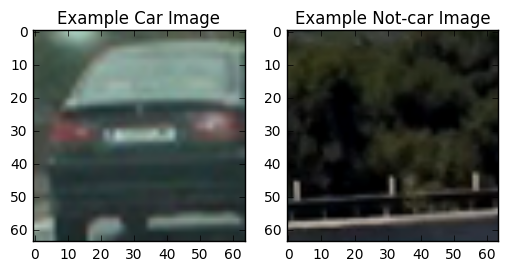

{'n_cars': 8792, 'image_shape': (64, 64, 3), 'data_type': dtype('uint8'), 'n_notcars': 9666}


In [3]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    test_image = sc.misc.imread(car_list[0]) 
    
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = test_image.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_image.dtype

    # Return data_dict
    return data_dict

data_info = data_look(cars, notcars)
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = sc.misc.imread(cars[car_ind]) 
notcar_image = sc.misc.imread(notcars[notcar_ind]) 

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

print(data_info)


# Get correct filters to use

In [4]:
# # Define a function to compute color histogram features  
# def color_hist(img, nbins=32, bins_range=(0, 256)):
#     # Compute the histogram of the color channels separately
#     channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
#     channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
#     channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
#     # Concatenate the histograms into a single feature vector
#     hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
#     # Return the individual histograms, bin_centers and feature vector
#     return hist_features

# # Define a function to return HOG features and visualization
# def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
#                         vis=False, feature_vec=True):
#     # Call with two outputs if vis==True
#     if vis == True:
#         features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
#                                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
#                                   visualise=vis, feature_vector=feature_vec)
#         return features, hog_image
#     # Otherwise call with one output
#     else:      
#         features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
#                        cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
#                        visualise=vis, feature_vector=feature_vec)
#         return features

# # Define a function to extract features from a list of images
# # Have this function call bin_spatial() and color_hist()
# def extract_features(imgs, cspace='RGB', cspacehog='HLS', 
#                         hist_bins=32, hist_range=(0, 256), orient=9, 
#                         pix_per_cell=8, cell_per_block=2, hog_channel=0):
#     # Create a list to append feature vectors to
#     features = []
#     convert =  isinstance(imgs[0], str)

#     # Iterate through the list of images
#     for img in imgs:
#         # Read in each one by one
#         if convert:
#             image = sc.misc.imread(img) 
#         else:
#             image = img
        
#         # apply color conversion if other than 'RGB'
#         if cspace != 'RGB':
#             if cspace == 'HSV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#             elif cspace == 'LUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
#             elif cspace == 'HLS':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#             elif cspace == 'YUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#             elif cspace == 'YCrCb':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
#         else: feature_image = np.copy(image)      
            
#         if cspacehog != 'RGB':
#             if cspacehog == 'HSV':
#                 feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#             elif cspacehog == 'LUV':
#                 feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
#             elif cspacehog == 'HLS':
#                 feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#             elif cspacehog == 'YUV':
#                 feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#             elif cspacehog == 'YCrCb':
#                 feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
#         else: feature_image_hog = np.copy(image)      
            
#         # Apply color_hist() also with a color space option now
#         hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
#         # Call get_hog_features() with vis=False, feature_vec=True
#         hog_features_0 = get_hog_features(feature_image_hog[:,:,0], orient, 
#                         pix_per_cell, cell_per_block, vis=False, feature_vec=True)
#         hog_features_1 = get_hog_features(feature_image_hog[:,:,1], orient, 
#                         pix_per_cell, cell_per_block, vis=False, feature_vec=True)
#         hog_features_2 = get_hog_features(feature_image_hog[:,:,2], orient, 
#                         pix_per_cell, cell_per_block, vis=False, feature_vec=True)
#         # Append the new feature vector to the features list
#         features.append(np.concatenate((hog_features_0, hog_features_1, hog_features_2, hist_features)))
#     # Return list of feature vectors
#     return features

# # used only for visualization purposes
# def extract_feature_1_img(img, cspace='RGB', cspacehog='HLS',
#                         hist_bins=32, hist_range=(0, 256), orient=9, 
#                         pix_per_cell=8, cell_per_block=2, hog_channel=0):
#     # Create a list to append feature vectors to
#     features = []
#     convert =  isinstance(img, str)

#     # Read in each one by one
#     if convert:
#         image = sc.misc.imread(img) 
#     else:
#         image = img

#     # apply color conversion if other than 'RGB'
#     if cspace != 'RGB':
#         if cspace == 'HSV':
#             feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#         elif cspace == 'LUV':
#             feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
#         elif cspace == 'HLS':
#             feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#         elif cspace == 'YUV':
#             feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#         elif cspace == 'YCrCb':
#             feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
#     else: feature_image = np.copy(image)      

#     if cspacehog != 'RGB':
#         if cspacehog == 'HSV':
#             feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#         elif cspacehog == 'LUV':
#             feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
#         elif cspacehog == 'HLS':
#             feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#         elif cspacehog == 'YUV':
#             feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#         elif cspacehog == 'YCrCb':
#             feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
#     else: feature_image_hog = np.copy(image)      

#     fig = plt.figure(figsize=(12,12))

#     plt.subplot(141)
#     plt.imshow(image)
#     plt.title('Original Car Image')
#     plt.subplot(142)
#     plt.imshow(feature_image[:,:,0], cmap = 'gray')
#     plt.title('Y')
#     plt.subplot(143)
#     plt.imshow(feature_image[:,:,1], cmap = 'gray')
#     plt.title('Cr')
#     plt.subplot(144)
#     plt.imshow(feature_image[:,:,2], cmap = 'gray')
#     plt.title('Cb')
    
#     plt.show()
        
#     # Apply color_hist() also with a color space option now
#     hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
#     # Call get_hog_features() with vis=False, feature_vec=True
#     hog_features_0, hog_image_0 = get_hog_features(feature_image_hog[:,:,0], orient, 
#                     pix_per_cell, cell_per_block, vis=True, feature_vec=True)
#     hog_features_1, hog_image_1 = get_hog_features(feature_image_hog[:,:,1], orient, 
#                     pix_per_cell, cell_per_block, vis=True, feature_vec=True)
#     hog_features_2, hog_image_2 = get_hog_features(feature_image_hog[:,:,2], orient, 
#                     pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    
#     print(np.min(hog_features_0), np.max(hog_features_0),np.min(hog_features_1), np.max(hog_features_1),np.min(hog_features_2), np.max(hog_features_2))
#     print(np.max(hist_features))
#     print(hog_features_0.shape, hog_features_1.shape, hog_features_2.shape, hist_features.shape)
    
#     # Return list of feature vectors
#     return hog_image_0, hog_image_1, hog_image_2, hist_features



In [5]:
# _CSPACE_ = 'YCrCb'
# _CSPACE_HOG_ = 'YCrCb'
# _HIST_BINS_ = 32
# _HIST_RANGE_ = (0, 256)
# _ORIENT_ = 8
# _PIX_PER_CELL_ = 8
# _CELL_PER_BLOCK_ = 2
# _HOG_CHANNEL_ = 1

f_params = get_features_parameters()


In [6]:
car_features = extract_features(cars, cspace=f_params['_CSPACE_'], cspacehog=f_params['_CSPACE_HOG_'], 
                        hist_bins=f_params['_HIST_BINS_'], hist_range=f_params['_HIST_RANGE_'], orient=f_params['_ORIENT_'], pix_per_cell=f_params['_PIX_PER_CELL_'], 
                        cell_per_block=f_params['_CELL_PER_BLOCK_'], hog_channel=f_params['_HOG_CHANNEL_'])
notcar_features = extract_features(notcars, cspace=f_params['_CSPACE_'], cspacehog=f_params['_CSPACE_HOG_'], 
                        hist_bins=f_params['_HIST_BINS_'], hist_range=f_params['_HIST_RANGE_'], orient=f_params['_ORIENT_'], pix_per_cell=f_params['_PIX_PER_CELL_'], 
                        cell_per_block=f_params['_CELL_PER_BLOCK_'], hog_channel=f_params['_HOG_CHANNEL_'])

print(notcar_features[2].shape, notcar_features[0].shape, notcar_features[1].shape)


(4800,) (4800,) (4800,)


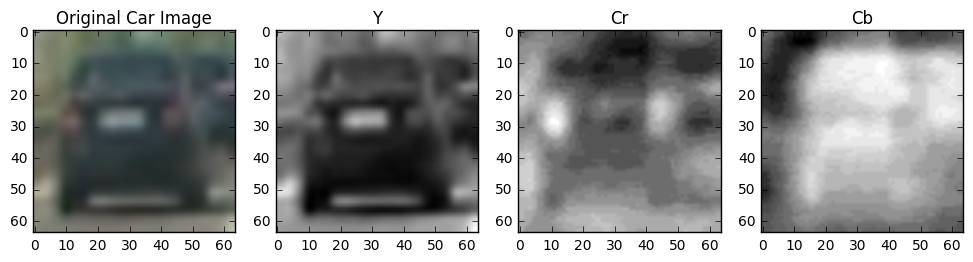

0.0 0.316370006676 0.0 0.312327025347 0.0 0.291937298359
2685
(1568,) (1568,) (1568,) (96,)


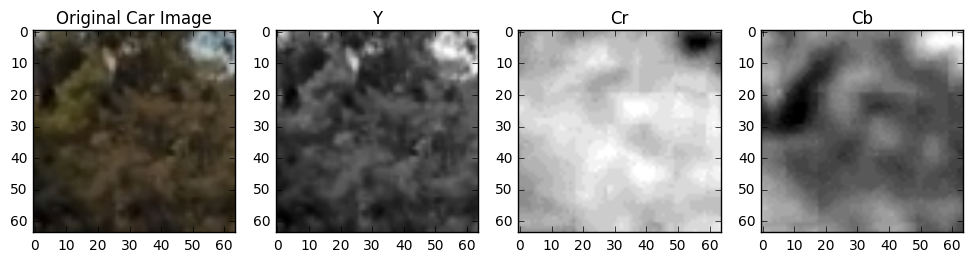

0.0 0.141817002132 0.0 0.223359625402 0.0 0.250907103243
3605
(1568,) (1568,) (1568,) (96,)


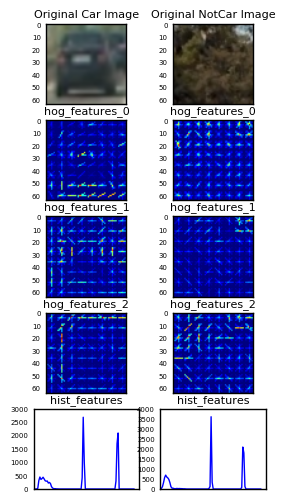

In [7]:
# For visualization only:

idx = 2

hog_image_0,  hog_image_1, hog_image_2, hist_features = extract_feature_1_img(cars[idx], cspace=f_params['_CSPACE_'], cspacehog=f_params['_CSPACE_HOG_'], 
                        hist_bins=f_params['_HIST_BINS_'], hist_range=f_params['_HIST_RANGE_'], orient=f_params['_ORIENT_'], pix_per_cell=f_params['_PIX_PER_CELL_'], 
                        cell_per_block=f_params['_CELL_PER_BLOCK_'], hog_channel=f_params['_HOG_CHANNEL_'])
hog_image_0n,  hog_image_1n, hog_image_2n, hist_featuresn = extract_feature_1_img(notcars[idx], cspace=f_params['_CSPACE_'], cspacehog=f_params['_CSPACE_HOG_'], 
                        hist_bins=f_params['_HIST_BINS_'], hist_range=f_params['_HIST_RANGE_'], orient=f_params['_ORIENT_'], pix_per_cell=f_params['_PIX_PER_CELL_'], 
                        cell_per_block=f_params['_CELL_PER_BLOCK_'], hog_channel=f_params['_HOG_CHANNEL_'])

imgplot = sc.misc.imread(cars[idx])
imgplotn = sc.misc.imread(notcars[idx])

fig = plt.figure(figsize=(3,6))

plt.subplot(521)
plt.imshow(imgplot)
plt.title('Original Car Image', fontsize = 8)
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='on', labeltop='off', labelright='off', labelbottom='off', labelsize=5)
plt.subplot(523)
plt.imshow(hog_image_0)
plt.title('hog_features_0', fontsize = 8)
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='on', labeltop='off', labelright='off', labelbottom='off', labelsize=5)
plt.subplot(525)
plt.imshow(hog_image_1)
plt.title('hog_features_1', fontsize = 8)
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='on', labeltop='off', labelright='off', labelbottom='off', labelsize=5)
plt.subplot(527)
plt.imshow(hog_image_2)
plt.title('hog_features_2', fontsize = 8)
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='on', labeltop='off', labelright='off', labelbottom='off', labelsize=5)
plt.subplot(529)
plt.plot(hist_features)
plt.title('hist_features', fontsize = 8)
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='on', labeltop='off', labelright='off', labelbottom='off', labelsize=5)

plt.subplot(522)
plt.imshow(imgplotn)
plt.title('Original NotCar Image', fontsize = 8)
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='on', labeltop='off', labelright='off', labelbottom='off', labelsize=5)
plt.subplot(524)
plt.imshow(hog_image_0n)
plt.title('hog_features_0', fontsize = 8)
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='on', labeltop='off', labelright='off', labelbottom='off', labelsize=5)
plt.subplot(526)
plt.imshow(hog_image_1n)
plt.title('hog_features_1', fontsize = 8)
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='on', labeltop='off', labelright='off', labelbottom='off', labelsize=5)
plt.subplot(528)
plt.imshow(hog_image_2n)
plt.title('hog_features_2', fontsize = 8)
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='on', labeltop='off', labelright='off', labelbottom='off', labelsize=5)
plt.subplot(5,2,10)
plt.plot(hist_featuresn)
plt.title('hist_features', fontsize = 8)
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='on', labeltop='off', labelright='off', labelbottom='off', labelsize=5)

plt.show()

# Train SVM

In [8]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 
print(X.shape)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

(18458, 4800)


In [9]:
# Use a linear SVC 
svc = LinearSVC(C=1.0) 
clf = CalibratedClassifierCV(svc) # to know the actual probability
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(t2-t, 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', clf.score(X_train, y_train))
print('Test Accuracy of SVC = ', clf.score(X_test, y_test))
# Check the prediction time for a single sample
t=time.time()
prediction = clf.predict(X_test[0].reshape(1, -1))
t2 = time.time()
print(t2-t, 'Seconds to predict with SVC')


21.53595495223999 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.992686890574
0.0008580684661865234 Seconds to predict with SVC


In [48]:
# save the model to disk
# filename = 'finalized_model.sav'
# pickle.dump(clf, open(filename, 'wb'))
# filename = 'finalized_scaler.sav'
# pickle.dump(X_scaler, open(filename, 'wb')) 
